In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

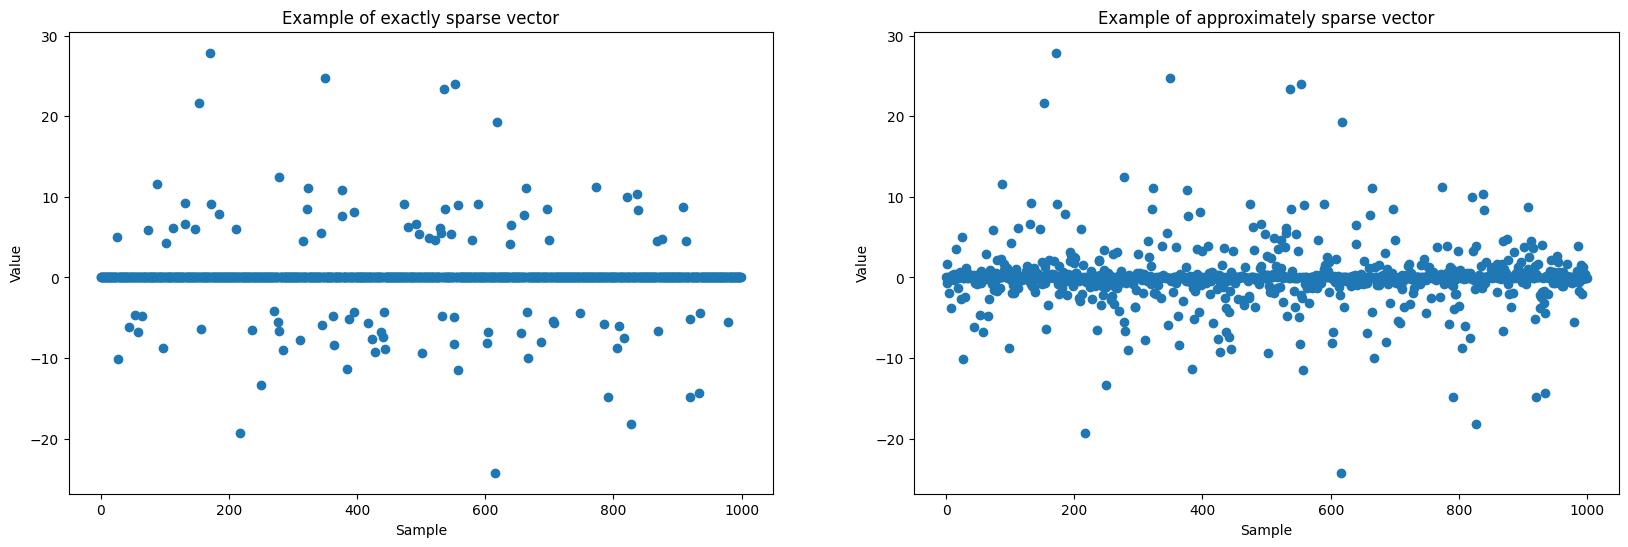

In [63]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer**

A sparse signal is a signal that has only k non null values with k << t with t the number of values in the domaine of this signal. An approximatly sparse signal differs from the previous one by the fact that it doesn't require all the non high values to be null. It is sufficient enough to have them below a certain threshold that we deem small enough.

Def of sparse signal : a signal $s \in ℜ^n$ is said to be k-sparse if only $k <<t$ with the pseudo-norm $||.||_0$ being the cardinal of the support of s
Def of Approximate sparse signal : only a small number k of the signal samples have a large amplitude thus the signal can be well approximated by a k-sparse signal.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

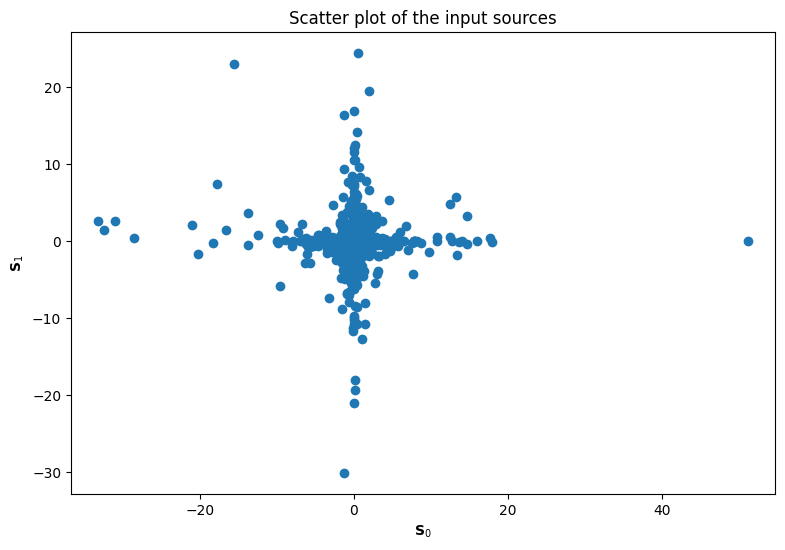

In [86]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation

# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.

S = np.zeros((n,t))
for i in range (n):
  approx_sparse = np.random.randn(t)**power
  S[i,:]=approx_sparse

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [87]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

**Answer**

By plotting the scatter of X we noitcie that we have two new pricipale direction. In fact, this is due to applying the transformation given by matrix A on the the star shape that we got above which lead to getting new orientations given by the matrix A.

By trying serval A matrices we notice that we change the direction. By changing the nose values we change how much the points are scatterd from the principale direction, although this is not visually very clear for since we use high SNR. And changing the powers leads to new ranges of values (how far are the points to the (0,0) point). For the power, we should use an odd value, otherwise, with an even one the input sources will be all positive, with an L shape (the angle will change when multiply by A*. </blockquote>

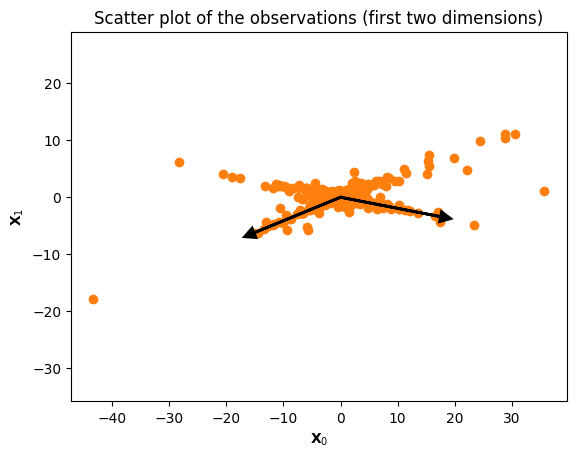

In [88]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

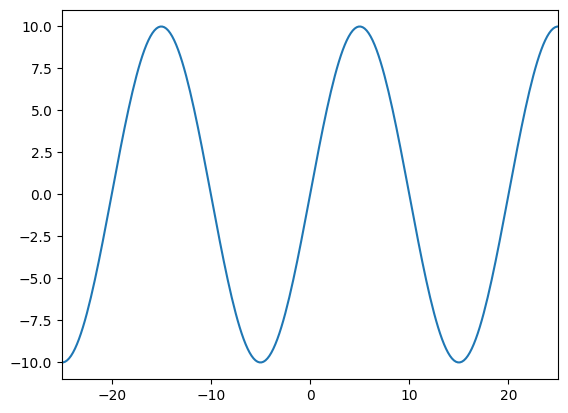

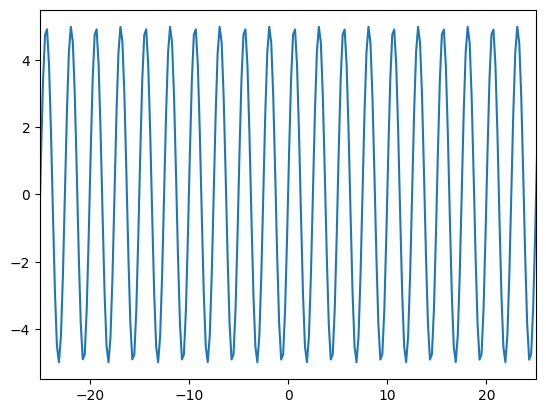

In [34]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer**

We use the DCT in order to transform the given signals into a new domain where they become approximately sparse signals (ideally we want to get exactly sparse signals if possible)

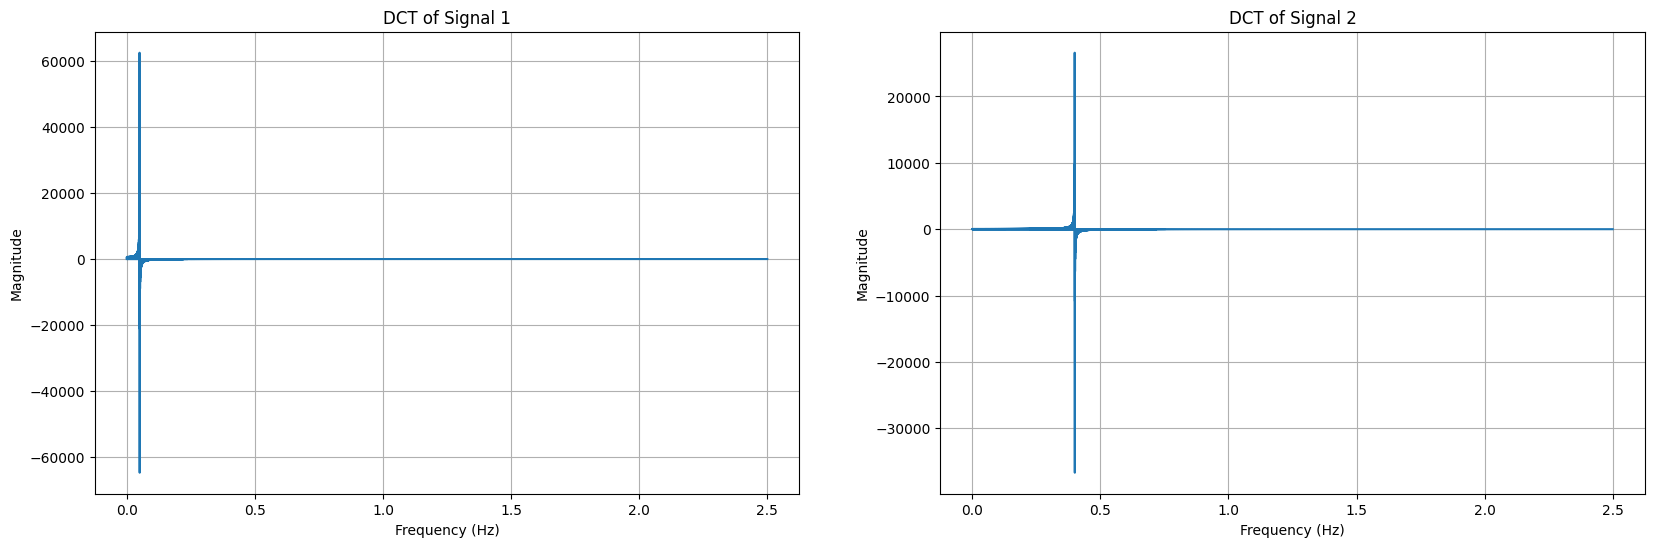

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

# Source generation
t = 10000
x_abs = np.linspace(-1000, 1000, t)

# Compute DCT
Sf = dct(S)

# Compute frequencies
sampling_rate = t / (x_abs[-1] - x_abs[0])  # Sampling rate
dct_freqs = np.linspace(0, sampling_rate / 2, len(Sf[0]))

# Plot the DCT coefficients against frequencies


fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(dct_freqs, Sf[0])
plt.title("DCT of Signal 1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)


fig.add_subplot(1,2,2)
plt.plot(dct_freqs, Sf[1])
plt.title("DCT of Signal 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

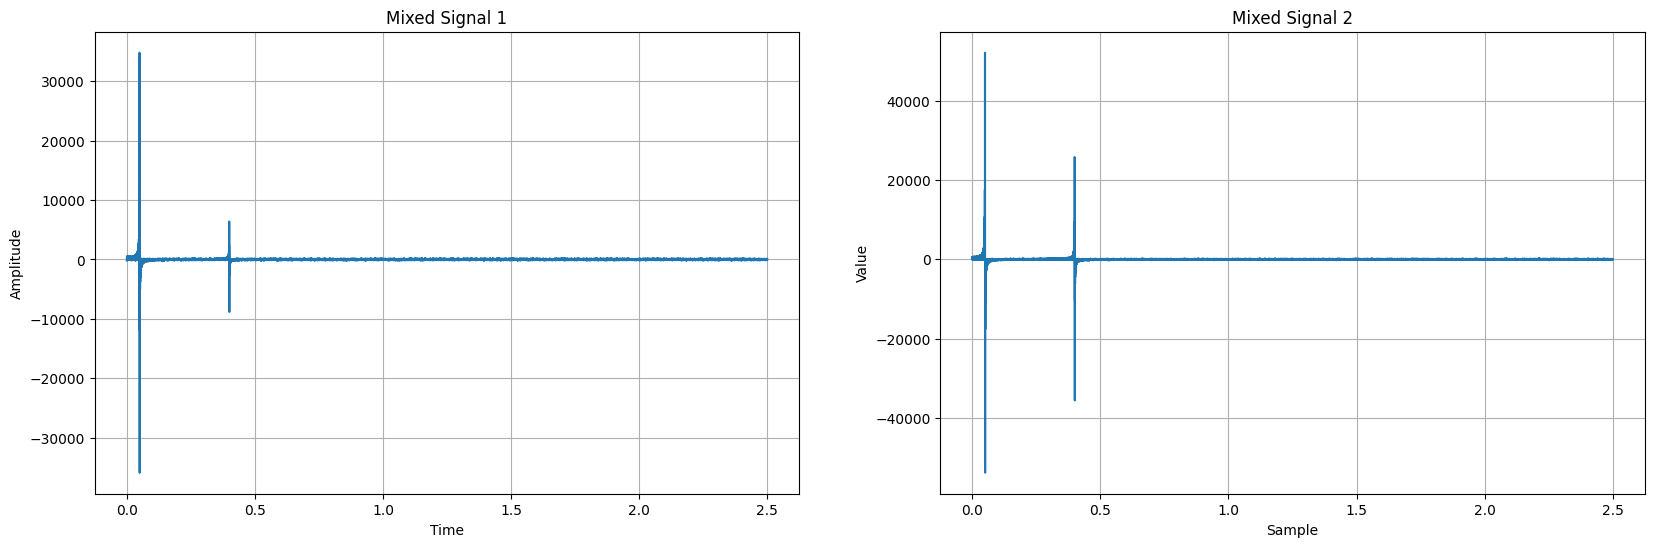

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mixing matrix A and source signals S
A = np.array([[0.5547002 , 0.24253563],
              [0.83205029, 0.9701425 ]])

# Mix the signals: X = AS + N
X = A @ S
X = X + 0.5 * np.random.randn(*X.shape)

# Compute DCT
Xf = dct(X)

# Compute frequencies
sampling_rate = t / (x_abs[-1] - x_abs[0])  # Sampling rate
dct_freqs = np.linspace(0, sampling_rate / 2, len(Sf[0]))


fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(dct_freqs, Xf[0, :])
plt.title('Mixed Signal 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

fig.add_subplot(1,2,2)
plt.plot(dct_freqs, Xf[1, :])
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Mixed Signal 2');
plt.grid(True)


**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Answer**

<blockquote>Cost function:
$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1$$

Where:

*  $\frac{1}{2}||X-AS||^2_F$ is the Data-fidelity.

*  $\lambda||S||_1$ is the Sparsity.


This problem is non-smooth because of the $||.||_1$ term. It's a convex problem because we fixed A.
</blockquote>

Compute the gradient along the S variable of the data-fidelity term.

**Answer**
The Gradient along the S variable is given by:

$$\nabla f(S^{(k)}) = A^T(AS-X)$$</blockquote>

Recall what the proximal operator of the l1-norm is.

**Answer**

The proximal operator of the $l_1$ norm is the soft-thresholding operator. That is:

$(prox_{\lambda |.||_1}(v))_i = S_{\lambda}(v) =  \begin{cases}
      v_i-\lambda &, v_i \ge \lambda \\
      0 &, |v_i\  \le \lambda \\
      v_i+\lambda &, v_i \le -\lambda
\end{cases}$

In [43]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0.)
  return S_est

Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer**

The Iterative Shrinkage Thresholding Algorithm (ISTA) is the combination of the gradient descent applied to the S variable of the data-fidelity term and the proximal operator of the $l_1$ norm of the soft-thresholding operator. By doing this we are able to minimize the cost function for the non-blind sparse source separation.

In [44]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((A.shape[1],X.shape[1]))
    gamma = 0.9/np.linalg.norm(np.matmul(A.T,A))
    for i in range(nbIt):
      S_est = prox_l1(S_est - gamma*(np.matmul(A.T,(np.matmul(A,S_est)-X))),lamb)
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

In [49]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer**

We should choose $\lambda$ greater than zero. Because with a lambda equal to zero we won't be penalizing the non sparsity of S and with lamda negative we will be rewarding greater norm of S. Increasing $\lambda$ increases the regularization. As a consequence, we will loose more and more signals, that progressively have values more distant than zero. <br><br> We can observe that graphically, the results obtained are verry similar to our original S above.

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7a93d0b551b0>])

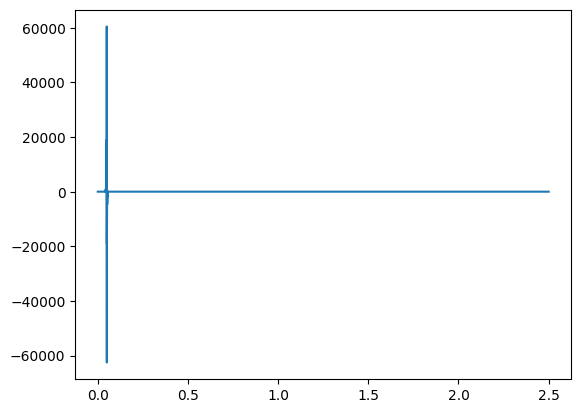

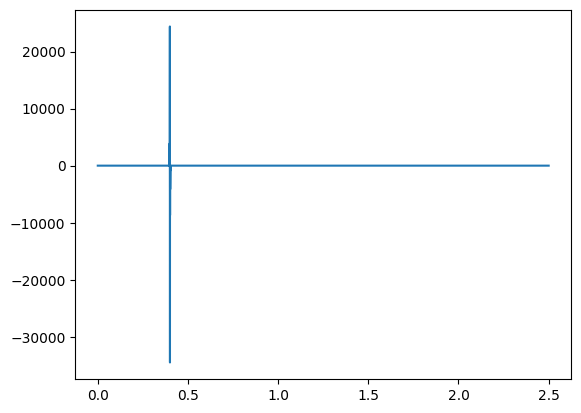

In [50]:
plt.figure(),plt.plot(np.linspace(0,2.5,t),(S_estf[0]))
plt.figure(),plt.plot(np.linspace(0,2.5,t),(S_estf[1]))


Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

(-25.0, 25.0)

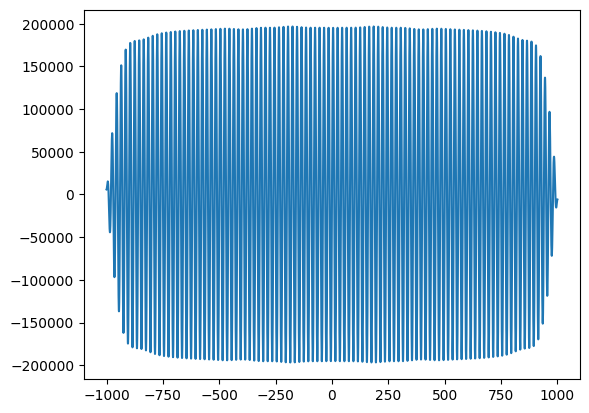

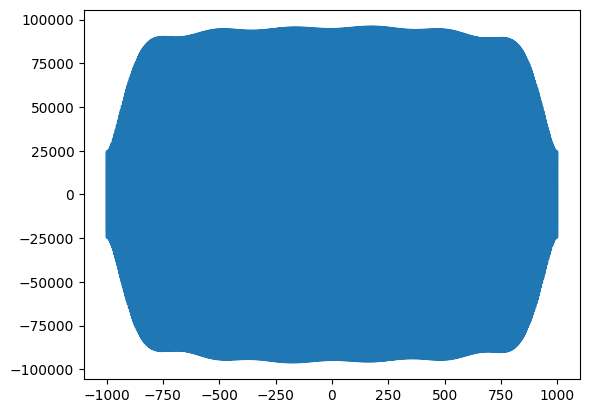

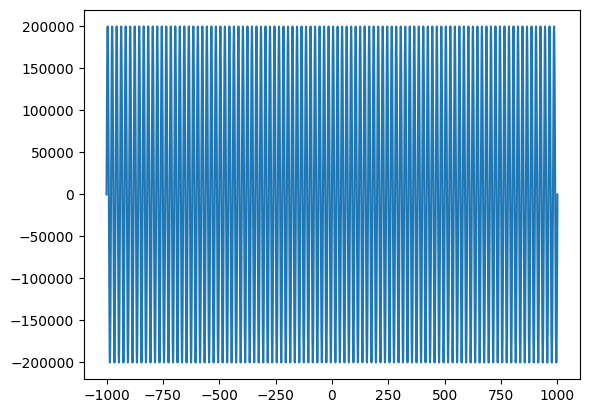

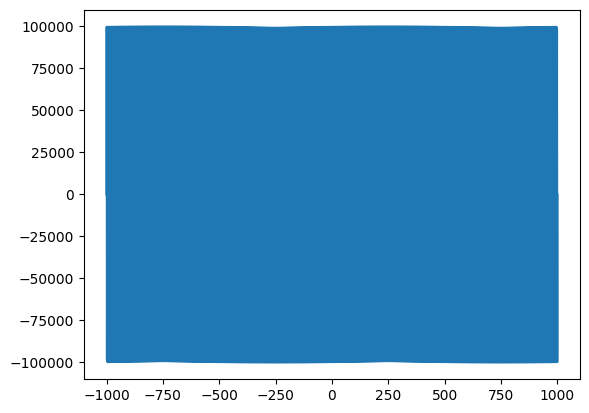

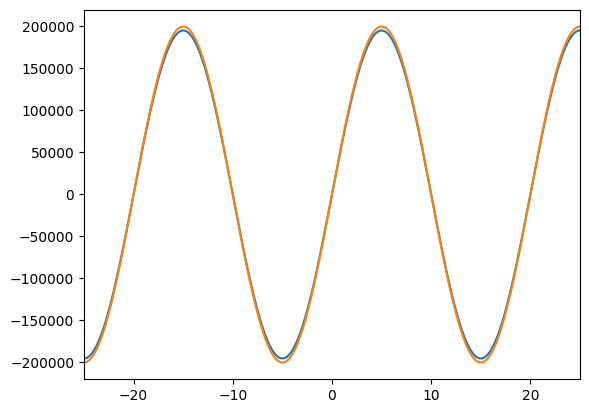

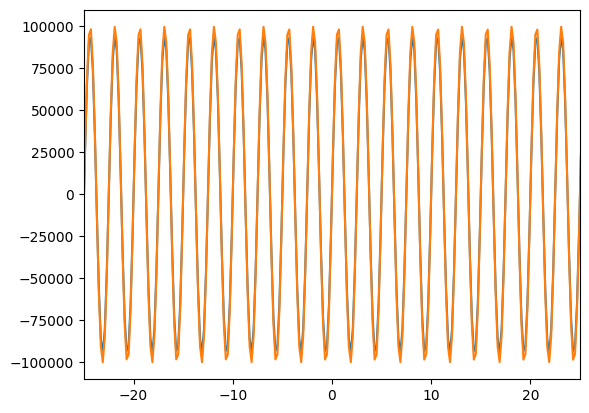

In [54]:
Sf = sff.idct(S_estf)

plt.figure(),plt.plot(x_abs, Sf[0])
plt.figure(),plt.plot(x_abs, Sf[1])
plt.figure(),plt.plot(x_abs, S[0]*20000)
plt.figure(),plt.plot(x_abs, S[1]*20000)

plt.figure()
plt.plot(x_abs, Sf[0])
plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, Sf[1])
plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])


**Answer**

We can observe above that we were able to obtain the original sinus signals from our ISTA estimation of S. To make Sf equal to S, we need to multiply S amplitude by 20 000 and also, it can be seen in the graph that for large values in magnitude, the estimated S decreases in amplitude.

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




Recall what the gradient of the data fidelity term over A is.

**Answer**

The cost function writes :
$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1+\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$$

Where:

*  $\frac{1}{2}||X-AS||^2_F$ is the Data-fidelity.

*  $\lambda||S||_1$ is the Sparsity.

*  $\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$ is the oblique constraint.

This problem is non-smooth because of the $||.||_1$ term.

This cost function is non-convex.

The gradient of the data fidelity term over A can be writen as :
$$\nabla f(S^{(k)}) = A^T(AS-X)$$

Compte the proximal operator of the oblique constraint. Implement it.

In [55]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        A[:, j] = A[:, j]/max(1, np.linalg.norm(A[:, j]))
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [56]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((n,X.shape[1]))
    A_est = np.eye(X.shape[0],n)
    for i in range(nbIt):
      S_est = prox_l1(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)+1e-16))*(np.dot(A_est.T,(X - np.dot(A_est,S_est)))), lamb)
      A_est = prox_oblique(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)+1e-16))*np.dot((X - np.dot(A_est,S_est)),S_est.T))

    return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

(-25.0, 25.0)

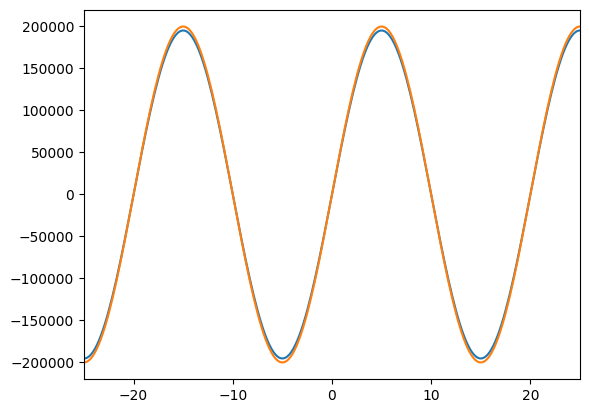

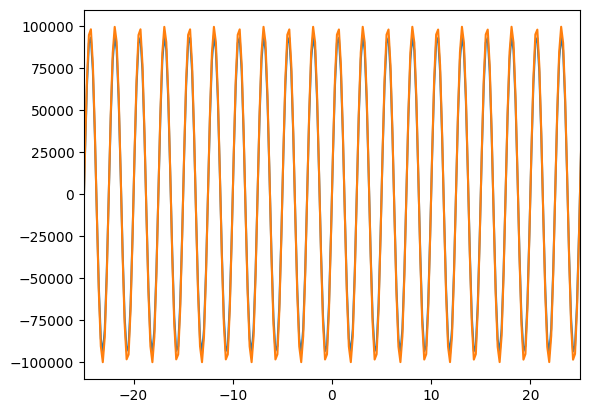

In [57]:
A_fest, S_fest = PALM(Xf, n=2, lamb=1000, nbIt=1000)

S_fest = sff.idct(S_fest)

plt.figure()
plt.plot(x_abs, S_fest[0])
plt.plot(x_abs,200000*np.sin(2*np.pi*0.05*x_abs))
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, S_fest[1])
plt.plot(x_abs,100000*np.sin(2*np.pi*0.4*x_abs))
plt.xlim([-25,25])

In [58]:
print('Matrix A:',A)
print('Matrix A_est: ',A_fest)

Matrix A: [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Matrix A_est:  [[0.55555242 0.24126662]
 [0.83148151 0.97045887]]


According to the above plots, the separation is almost identical. We can see that the sinus signal obtained in the method PALM is really similar to the one we started with.

After comparing the estimated matrix A_est against the true matrix A we noitice that the values are almost equal. which can be seen as a good match as well.
